In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import matplotlib.pyplot as plt
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime
import warnings
import math
from math import sqrt
warnings.filterwarnings("ignore") # ignore messy numpy warnings

# include below line if you are using Jupyter Notebook
%matplotlib inline

result_param=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']

# one-step Holt Winter’s Exponential Smoothing forecast
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def ets_param(history, config):
    t,d,s,p,b,r = config
    # define model
    history = np.array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # save parameter
    result_param["HoltsWinter"] = [model_fit.params[p] for p in params] + [model_fit.sse]
    return result_param

# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(predictions[i])
    # estimate prediction error
   # error = measure_rmse(test, predictions)
    return predictions

### sMape
def smape(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

# Product A

sMAPE: 24.99
RMSE: 6786
           HoltsWinter
$\alpha$  5.263107e-02
$\beta$   5.264070e-02
$\phi$             NaN
$\gamma$  6.315825e-01
$l_0$     1.345011e+04
$b_0$     0.000000e+00
SSE       9.033575e+08


,predicted_demand,actual_demand
Date,,
2018-01-31,29979,30852
2018-02-28,28348,34192
2018-03-31,37879,36856
2018-04-30,33112,38645
2018-05-31,27759,40615
2018-06-30,27832,34559
2018-07-31,21007,28915
2018-08-31,14035,24837
2018-09-30,10581,18513


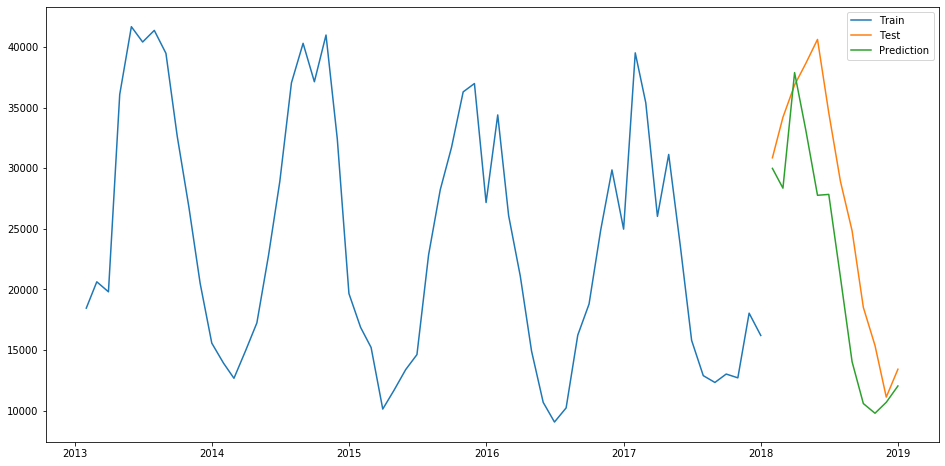

In [43]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product A']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['add',False,'add',14,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product B

sMAPE: 24.75
RMSE: 4960
           HoltsWinter
$\alpha$  5.822027e-02
$\beta$   5.822026e-02
$\phi$             NaN
$\gamma$  7.224755e-01
$l_0$     1.241629e+04
$b_0$     7.113766e+01
SSE       5.561251e+08


,predicted_demand,actual_demand
Date,,
2018-01-31,24551,26273
2018-02-28,20472,24597
2018-03-31,28935,30794
2018-04-30,23198,14844
2018-05-31,19489,27268
2018-06-30,18866,26435
2018-07-31,16883,20528
2018-08-31,10179,16546
2018-09-30,11943,16006


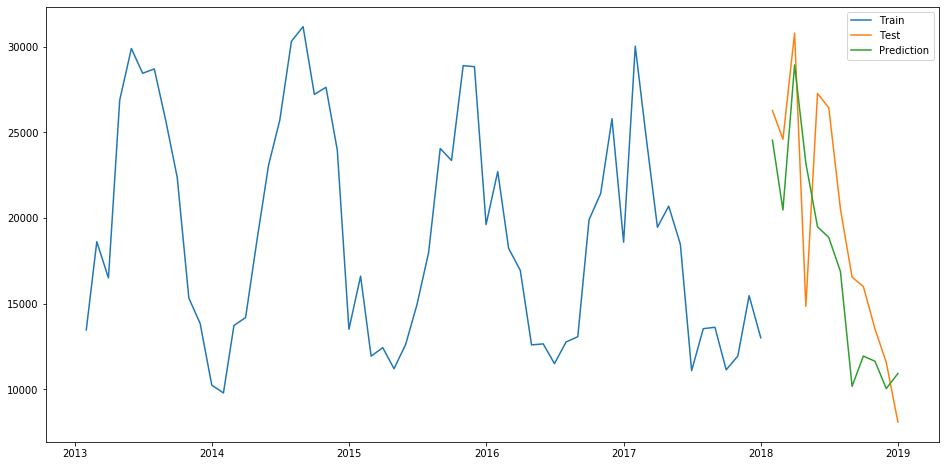

In [44]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product B']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['add',False,'add',14,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product C

sMAPE: 24.41
RMSE: 3219
           HoltsWinter
$\alpha$  5.263551e-02
$\beta$   5.263551e-02
$\phi$             NaN
$\gamma$  9.473686e-01
$l_0$     2.249667e+03
$b_0$     0.000000e+00
SSE       2.845033e+08


,predicted_demand,actual_demand
Date,,
2018-01-31,5408,9495
2018-02-28,8580,8231
2018-03-31,7325,10794
2018-04-30,10030,10851
2018-05-31,8740,13464
2018-06-30,14484,8306
2018-07-31,10554,12006
2018-08-31,12187,12259
2018-09-30,13946,17943


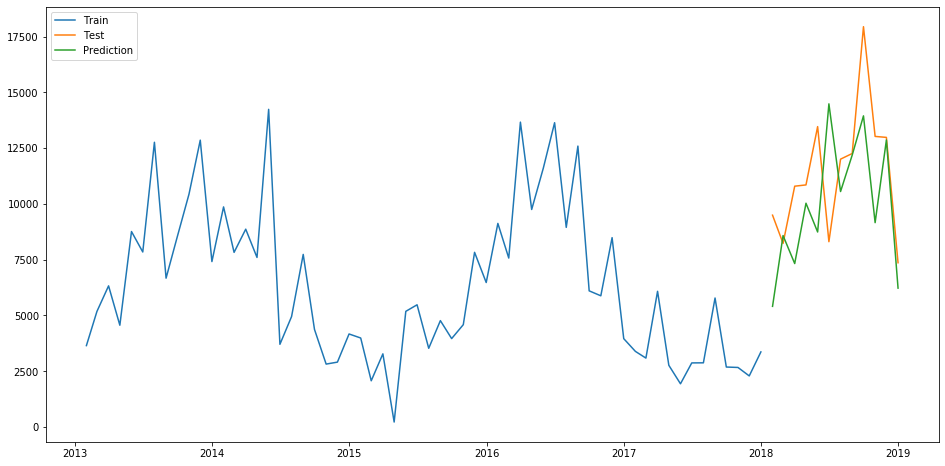

In [45]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product C']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['add',False,'add',27,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product D

sMAPE: 21.73
RMSE: 13513
           HoltsWinter
$\alpha$  2.105263e-01
$\beta$   5.263158e-02
$\phi$             NaN
$\gamma$  7.894737e-01
$l_0$     1.870200e+04
$b_0$     1.014409e+00
SSE       1.622609e+09


,predicted_demand,actual_demand
Date,,
2018-01-31,38243,44507
2018-02-28,40689,42925
2018-03-31,32945,49669
2018-04-30,59705,25956
2018-05-31,52019,53731
2018-06-30,51226,54465
2018-07-31,49083,56251
2018-08-31,46864,58880
2018-09-30,35622,56171


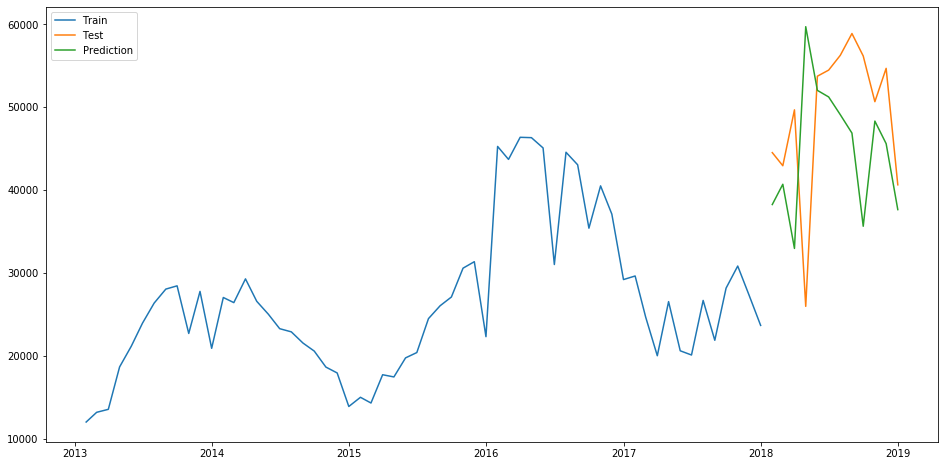

In [46]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product D']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['mul',False,'mul',27,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product E

sMAPE: 24.30
RMSE: 1879
           HoltsWinter
$\alpha$  5.263158e-02
$\beta$   5.263158e-02
$\phi$             NaN
$\gamma$  4.736842e-01
$l_0$     2.932333e+03
$b_0$     2.076813e+01
SSE       9.651616e+07


,predicted_demand,actual_demand
Date,,
2018-01-31,3963,3028
2018-02-28,5734,6219
2018-03-31,5377,8163
2018-04-30,5724,8249
2018-05-31,6744,7905
2018-06-30,6722,7115
2018-07-31,9375,8213
2018-08-31,8912,6445
2018-09-30,9123,6834


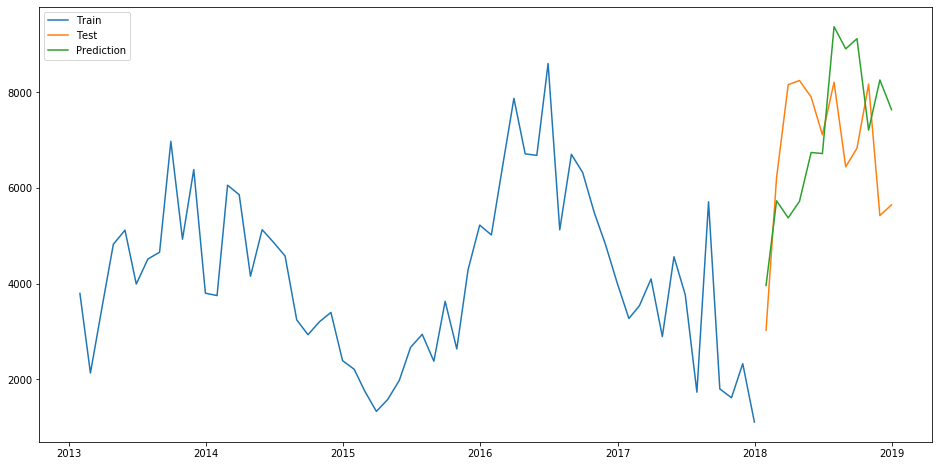

In [47]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product E']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['add',False,'mul',29,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product F

sMAPE: 25.75
RMSE: 23520
           HoltsWinter
$\alpha$  5.263158e-02
$\beta$   5.263157e-02
$\phi$             NaN
$\gamma$  5.263158e-02
$l_0$     5.350667e+03
$b_0$     1.048234e+00
SSE       5.581347e+09


,predicted_demand,actual_demand
Date,,
2018-01-31,53332,56316
2018-02-28,43300,47718
2018-03-31,53496,73871
2018-04-30,34798,39953
2018-05-31,63804,88125
2018-06-30,42493,92334
2018-07-31,70627,102757
2018-08-31,81058,107549
2018-09-30,75786,103683


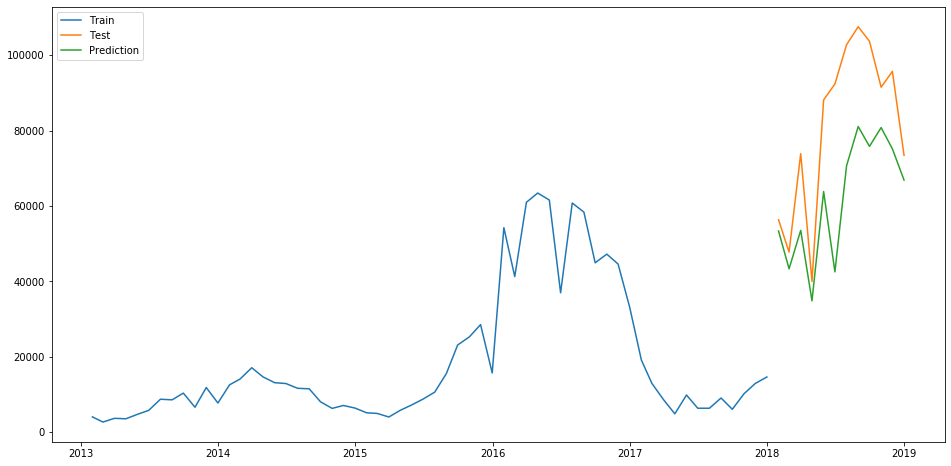

In [52]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product F']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasonal_period, use_boxcox, remove_bias]
config = ['mul',False,'mul',27,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product G

sMAPE: 11.69
RMSE: 1132
           HoltsWinter
$\alpha$  5.263158e-02
$\beta$   5.263158e-02
$\phi$             NaN
$\gamma$  3.157895e-01
$l_0$     6.398858e+03
$b_0$     4.097222e+00
SSE       3.446475e+07


,predicted_demand,actual_demand
Date,,
2018-01-31,6825,7064
2018-02-28,6903,9749
2018-03-31,6655,5697
2018-04-30,6849,6355
2018-05-31,7938,7035
2018-06-30,6978,6611
2018-07-31,6436,6298
2018-08-31,6531,7585
2018-09-30,6987,5120


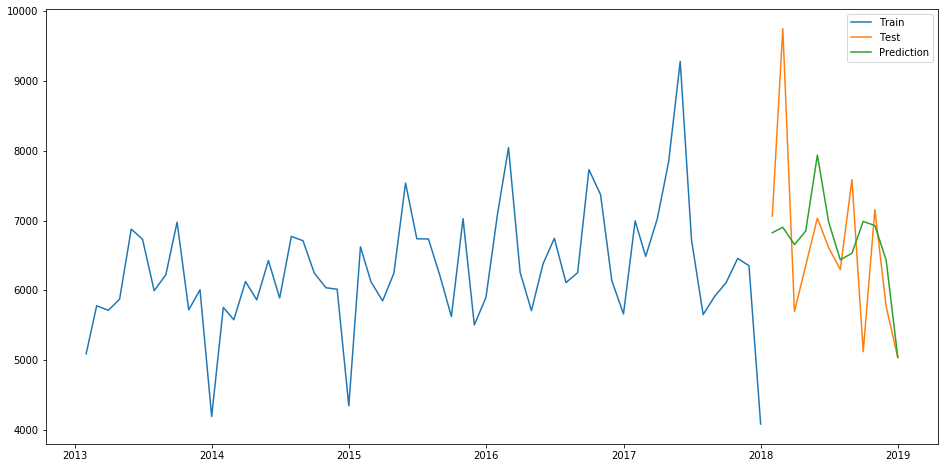

In [53]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product G']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasonal_period, use_boxcox, remove_bias]
config = ['add',False,'mul',12,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product H

sMAPE: 27.46
RMSE: 1208
           HoltsWinter
$\alpha$  1.031511e-01
$\beta$            NaN
$\phi$             NaN
$\gamma$  5.377481e-01
$l_0$     1.923007e+03
$b_0$              NaN
SSE       5.144197e+07


,predicted_demand,actual_demand
Date,,
2018-01-31,5220,2753
2018-02-28,3486,3636
2018-03-31,1727,1643
2018-04-30,1452,1545
2018-05-31,1631,1631
2018-06-30,1656,2228
2018-07-31,3156,1764
2018-08-31,1454,2815
2018-09-30,5218,2562


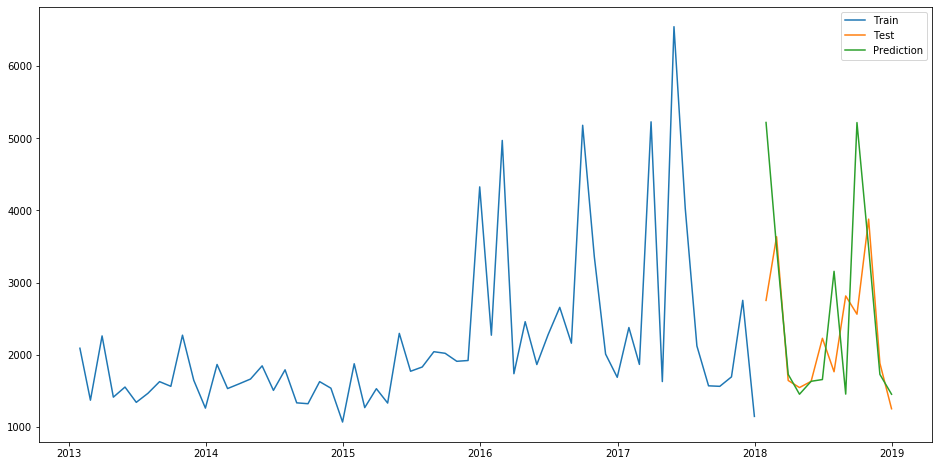

In [54]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product H']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = [None,False,'add',8,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product I

sMAPE: 13.48
RMSE: 2205
           HoltsWinter
$\alpha$  5.668874e-01
$\beta$            NaN
$\phi$             NaN
$\gamma$  0.000000e+00
$l_0$     8.469972e+03
$b_0$              NaN
SSE       2.467675e+08


,predicted_demand,actual_demand
Date,,
2018-01-31,14487,13556
2018-02-28,13707,13030
2018-03-31,13751,16275
2018-04-30,13830,14878
2018-05-31,14412,15880
2018-06-30,14660,12920
2018-07-31,13600,13360
2018-08-31,12827,11528
2018-09-30,14408,10373


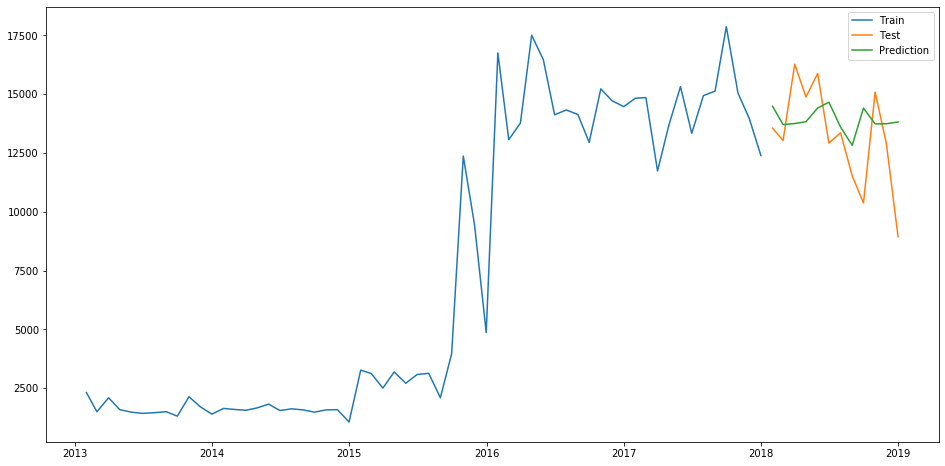

In [55]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product I']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = [None,False,'add',8,False,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)

# Product J

sMAPE: 12.78
RMSE: 1242
           HoltsWinter
$\alpha$  4.773167e-01
$\beta$   2.348147e-01
$\phi$    9.145202e-01
$\gamma$  0.000000e+00
$l_0$     2.438459e+00
$b_0$     3.667365e-03
SSE       2.018681e+08


,predicted_demand,actual_demand
Date,,
2018-01-31,6245,6889
2018-02-28,6068,7183
2018-03-31,5970,6968
2018-04-30,5769,6206
2018-05-31,5845,5611
2018-06-30,5518,5273
2018-07-31,5712,5196
2018-08-31,5640,6396
2018-09-30,5545,5025


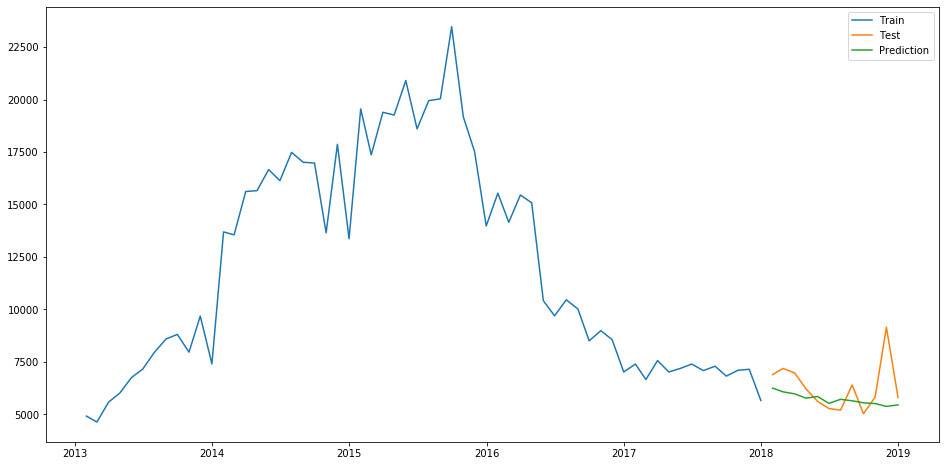

In [58]:
# load data
series = pd.read_csv('master2.csv',index_col=0, parse_dates=True, squeeze=True)
series.head()
series = series['Product J']
series = series.resample('M').sum()

# Configuration [t,d,s,p,b,r] = [trend, dumped, seasonal, seasona_period, use_boxcox, remove_bias]
config = ['add',True,'add',7,True,False]
n_test = 12

#walk_forward_validation(series, n_test, config)

predictions = list()
# split dataset
train, test = train_test_split(series, n_test)
# seed history with training dataset
history = [x for x in train]
# step over each time-step in the test set
for i in range(len(test)):
    # fit model and make forecast for history
    yhat = exp_smoothing_forecast(history, config)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(predictions[i])
    parameter = ets_param(history, config)
# estimate prediction error
error = measure_rmse(test, predictions)
error2 = smape(test, predictions)
print('sMAPE: %.2f' % error2)
print('RMSE: %.0f' % error)
print(parameter)

# append predictions data to DataFrame and use test index
predictions_list = ()
predictions = np.vstack(predictions)
predictions_list = pd.DataFrame(data=predictions[0:],
                                     index = test.index)
predictions_list['actual_demand'] = test.values  
# Changing column names
predictions_list.columns = ['predicted_demand', 
                                 'actual_demand']

# Plot the prediction
plt.figure(figsize = (16,8))
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_list.predicted_demand, label = 'Prediction')
plt.legend(loc = 'best')

predictions_list.head(12).astype(int)